In [714]:
'''
!pip install pyyaml
!pip install matplotlib-venn
!pip install numpy
!pip install maya
'''
!pip install decorator==5.0.5

In [407]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
from pprint import pprint
import sqlite3
import yaml
import re
from datetime import datetime
import maya
from collections import Counter
from glob import glob
import ast
import json
from sklearn.preprocessing import StandardScaler

try: # for pip >= 10
    from pip._internal.req import parse_requirements
except ImportError: # for pip <= 9.0.3
    from pip.req import parse_requirements

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

import networkx as nx
import networkx.algorithms.community as nxcom

import bokeh.io
from bokeh.io import output_file, show
from bokeh.resources import INLINE
from bokeh.models import (BoxSelectTool, Circle, EdgesAndLinkedNodes, HoverTool,
                          MultiLine, NodesAndLinkedEdges, Plot, Range1d, TapTool,
                         BoxZoomTool, ResetTool, OpenURL, CustomJS, Column, SaveTool)
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook
from bokeh.models.graphs import from_networkx
from bokeh.models import TextInput, Button

%matplotlib inline

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

## Easier navigation:

------------------------------------

### 1. <a href='#setup1'>Setup timing csv</a>
### 2. <a href='#setup2'>Setup dependency/size csv</a>
### 3. <a href='#setup3'>Setup scrape csv</a>
------------------------------------
### 4. <a href='#e1'>Timing csv EDA</a>
### 5. <a href='#e2'>Dependency/size csv EDA</a>
### 6. <a href='#e3'>Scrape csv EDA</a>
------------------------------------
### 7. <a href='#merge'>Merge CSVs</a>
------------------------------------
### 8. <a href='#c1'>Correlational plots for time vs size</a>

<a name='setup1'></a>
## 1. Setup timing csv


 - Time to install package
 
 
 Columns: ['library', 'real avg', 'real std', 'real max', 'count', 'sys avg','sys std', 'sys max', 'user avg', 'user std', 'user max']
<br>

In [791]:
t_df = pd.read_csv("combined_times.csv").drop([0,1])
t_df.columns = ["library", "real avg", "real std", "real max", "count", "sys avg", "sys std", "sys max", "user avg", "user std", "user max"]
t_df["library"] = t_df["library"].str.lower()
t_df = t_df.reset_index().drop("index", axis=1)
#t_df.iloc[:, 1:] = t_df.iloc[:, 1:].astype(float)
for col in t_df.columns:
    if col != "library":
        t_df[col] = t_df[col].astype(float)

# temporary solution
#t_df = t_df[~t_df.library.duplicated(keep='first')]

t_df

,library,real avg,real std,real max,count,sys avg,sys std,sys max,user avg,user std,user max
0,absl-py,1.00900,0.029405,1.046,4.0,0.09325,0.019085,0.109,0.87275,0.031063,0.903
1,abtem,14.67500,NaN,14.675,1.0,1.02000,NaN,1.020,12.90400,NaN,12.904
2,adal,3.52600,NaN,3.526,1.0,0.23100,NaN,0.231,3.07300,NaN,3.073
3,adjusttext,6.73650,0.111530,6.838,4.0,0.50925,0.046450,0.565,6.02775,0.147464,6.166
4,advertools,18.20400,NaN,18.204,1.0,1.38100,NaN,1.381,16.22600,NaN,16.226
...,...,...,...,...,...,...,...,...,...,...,...
1595,zict,0.92025,0.042248,0.971,4.0,0.11525,0.023386,0.148,0.76450,0.034809,0.805
1596,zipfile2,0.96200,NaN,0.962,1.0,0.12000,NaN,0.120,0.78700,NaN,0.787
1597,zipp,0.89300,0.042214,0.950,4.0,0.10300,0.011916,0.118,0.76150,0.054433,0.829
1598,zope.interface,1.35150,0.067461,1.446,4.0,0.12225,0.016581,0.140,1.18550,0.064831,1.274


<a name='setup2'></a>
## 2. Setup dependency/size csv

 - Package size
 - Package dependencies
 
  
 Columns: ['library', 'dependencies', 'size', 'size_full']
<br>

3 methods for string representation of list to list:
- Eval()
- ast_literal eval()
- strip 

In [1235]:
ds_df = pd.read_csv("combined_depsize.csv").drop("Unnamed: 0", axis=1)

for i in np.arange(len(ds_df["dependencies"])):
    try:
        ds_df["dependencies"][i] = eval(ds_df["dependencies"][i])
        for j in np.arange(len(ds_df["dependencies"][i])):
            ds_df["dependencies"][i][j] = ds_df["dependencies"][i][j].lower().strip()
    except:
        pass
    
ds_df

,library,dependencies,size,size_full
0,matplotlib,"[numpy, cycler, pillow, python-dateutil, pypar...",60.000,35M /home/ubuntu/ve/randomenv/lib/python3.6/si...
1,numpy,[],25.000,25M /home/ubuntu/ve/randomenv/lib/python3.6/si...
2,pandas,"[pytz, numpy, python-dateutil]",74.800,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...
3,scipy,[numpy],87.000,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...
4,ipywidgets,"[widgetsnbextension, traitlets, ipykernel, nbf...",78.292,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...
...,...,...,...,...
1595,sphinxcontrib-svg2pdfconverter,[sphinx],65.900,30M /home/ubuntu/ve/randomenv/lib/python3.6/si...
1596,brian2tools,"[setuptools, pylems, brian2, setuptools-scm, m...",150.516,64M /home/ubuntu/ve/randomenv/lib/python3.6/si...
1597,kneed,"[numpy, matplotlib, scipy]",122.076,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...
1598,hepunits,[],0.092,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...


In [1236]:
len(ds_df[ds_df["dependencies"] == "ERROR"])

116

In [1237]:
len(ds_df[ds_df["size"] == 0])

322

<a name='setup3'></a>
## 3. Setup scrape csv

 
 - Package stats
 - Package versions
 
 Columns: ['library', 'Contributors', 'Dependencies', 'Dependent packages', 'Dependent repositories', 'First release', 'Forks', 'Latest release', 'Open Issues/PRs', 'Repository size', 'SourceRank', 'Stars', 'Total releases', 'Version Number', 'Version Time', 'Watchers']
<br>

In [1238]:
pd.read_csv("scraper_final.csv")["Version Number"][1]

"['0.12', '0.11', '0.10', '0.9.3', '0.9.2', '0.9.1', '0.9', '0.8', '0.7', '0.6', '0.5', '0.4', '0.3', '0.2', '0.1']"

In [1239]:
with open('scraper_0_999.txt') as f:
    reloaded_example = json.load(f)

In [1240]:
s_df = pd.read_json(reloaded_example)
s_df

,library,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,Latest release,Open Issues/PRs,Repository size,SourceRank,Stars,Total releases,Version Number,Version Time,Watchers
0,matplotlib,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",5874.0,2 months ago,1663.0,377.00,28.0,13806.0,68.0,"[3.4.2, 3.4.1, 3.4.0, 3.4.0rc3, 3.4.0rc2, 3.4....","[1620452820000, 1617178680000, 1616745000000, ...",569.0
1,numpy,736.0,0.0,25500.0,84900.0,"Dec 2, 2006",5616.0,about 18 hours ago,2333.0,90.20,29.0,17445.0,101.0,"[1.21.0, 1.21.0rc2, 1.21.0rc1, 1.20.3, 1.20.2,...","[1624369140000, 1623170280000, 1621871700000, ...",560.0
2,pandas,970.0,0.0,14500.0,38400.0,"Dec 25, 2009",12560.0,about 18 hours ago,3669.0,219.00,28.0,30122.0,93.0,"[1.2.5, 1.3.0rc1, 1.2.4, 1.2.3, 1.2.2, 1.2.1, ...","[1624369260000, 1623614160000, 1618252980000, ...",1113.0
3,scipy,680.0,1.0,10400.0,43400.0,"Jul 27, 2010",3755.0,3 days ago,1667.0,128.00,26.0,8312.0,66.0,"[1.7.0, 1.7.0rc2, 1.7.0rc1, 1.6.3, 1.6.2, 1.6....","[1624205460000, 1623684360000, 1623000180000, ...",329.0
4,ipywidgets,NaN,8.0,734.0,7470.0,"Aug 3, 2015",NaN,"Feb 22, 2021",NaN,NaN,17.0,NaN,123.0,"[8.0.0a4, 8.0.0a3, 8.0.0a2, 8.0.0a1, 7.6.3, 7....","[1614027540000, 1613001060000, 1612999980000, ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,imgkit,7.0,1.0,11.0,31.0,"Jan 30, 2017",62.0,"Apr 10, 2021",NaN,185.00,16.0,628.0,31.0,"[1.2.2, 1.2.1, 1.2.0, 1.1.6, 1.1.5, 1.1.4, 1.1...","[1618062540000, 1617971280000, 1617805620000, ...",17.0
996,sphinx_tabs,14.0,11.0,41.0,178.0,"Jan 22, 2017",43.0,12 days ago,NaN,1.20,18.0,157.0,28.0,"[3.1.0, 3.0.0, 2.1.0, 2.0.1, 2.0.0, 1.3.0, 1.2...","[1623423840000, 1620765480000, 1615401300000, ...",9.0
997,lea,0.0,0.0,0.0,21.0,"Jul 27, 2013",3.0,"Nov 13, 2020",NaN,4.64,9.0,NaN,50.0,"[3.4.0, 3.3.2, 3.3.1, 3.3.0, 3.2.3, 3.2.2, 3.2...","[1605297000000, 1602680580000, 1602678780000, ...",5.0
998,requests-html,41.0,7.0,135.0,182.0,"Feb 24, 2018",823.0,"Feb 17, 2019",NaN,2.85,18.0,11900.0,36.0,"[0.10.0, 0.9.0, 0.8.4, 0.8.3, 0.8.2, 0.8.1, 0....","[1550434440000, 1521633000000, 1521632820000, ...",279.0


<a name='merge'></a>
## 4. Merge CSVs

<br>

In [1241]:
merge_df = ds_df.merge(s_df, on="library").merge(t_df, on="library")

In [1242]:
df = merge_df.drop(merge_df[merge_df["dependencies"] == "ERROR"].index)

In [1243]:
df

,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,real avg,real std,real max,count,sys avg,sys std,sys max,user avg,user std,user max
0,matplotlib,"[numpy, cycler, pillow, python-dateutil, pypar...",60.000,35M /home/ubuntu/ve/randomenv/lib/python3.6/si...,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",5874.0,...,5.81200,0.222030,6.137,4.0,0.44825,0.042248,0.496,5.16300,0.152169,5.348
1,numpy,[],25.000,25M /home/ubuntu/ve/randomenv/lib/python3.6/si...,736.0,0.0,25500.0,84900.0,"Dec 2, 2006",5616.0,...,3.13700,0.090664,3.214,4.0,0.31375,0.010874,0.323,2.78200,0.082571,2.846
2,pandas,"[pytz, numpy, python-dateutil]",74.800,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,970.0,0.0,14500.0,38400.0,"Dec 25, 2009",12560.0,...,6.56925,0.259008,6.884,4.0,0.44500,0.053179,0.492,6.02050,0.246785,6.274
3,scipy,[numpy],87.000,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,680.0,1.0,10400.0,43400.0,"Jul 27, 2010",3755.0,...,5.83550,0.124538,5.990,4.0,0.58025,0.089418,0.712,5.19375,0.056700,5.256
4,ipywidgets,"[widgetsnbextension, traitlets, ipykernel, nbf...",78.292,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,8.0,734.0,7470.0,"Aug 3, 2015",NaN,...,11.61050,0.255701,11.959,4.0,0.85050,0.023058,0.877,9.99075,0.244549,10.311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,imgkit,[six],0.060,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,7.0,1.0,11.0,31.0,"Jan 30, 2017",62.0,...,0.98500,0.057660,1.059,4.0,0.11350,0.010472,0.128,0.81750,0.051176,0.869
996,sphinx_tabs,"[sphinx, pygments, docutils]",65.700,30M /home/ubuntu/ve/randomenv/lib/python3.6/si...,14.0,11.0,41.0,178.0,"Jan 22, 2017",43.0,...,5.99350,0.336244,6.405,4.0,0.48900,0.062562,0.550,5.00325,0.155644,5.186
997,lea,[],0.716,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,0.0,0.0,0.0,21.0,"Jul 27, 2013",3.0,...,1.69300,0.092926,1.818,4.0,0.18450,0.014201,0.201,1.43150,0.022174,1.460
998,requests-html,"[bs4, fake-useragent, requests, parse, pyppete...",22.080,15M /home/ubuntu/ve/randomenv/lib/python3.6/si...,41.0,7.0,135.0,182.0,"Feb 24, 2018",823.0,...,6.08875,0.255098,6.297,4.0,0.51200,0.093177,0.581,5.21125,0.156274,5.397


<a name='tree'></a>
## 6. Dependencies tree

<br>

In [1244]:
edge_list = pd.DataFrame(columns= ['Library', 'Dependency', 'Weight'])

counter = 0
a = datetime.now()
for index, row in df.iterrows():
    source = row["library"]
    for d in row["dependencies"]:
        edge_list = edge_list.append({'Library': source, 'Dependency': d, 'Weight': 1}, ignore_index=True)
    counter += 1
    if counter % 1000 == 0:
        b = datetime.now()
        print(str(counter) + ": " + str((b - a).seconds))
        a = datetime.now()
            
edge_list

,Library,Dependency,Weight
0,matplotlib,numpy,1
1,matplotlib,cycler,1
2,matplotlib,pillow,1
3,matplotlib,python-dateutil,1
4,matplotlib,pyparsing,1
...,...,...,...
2862,requests-html,requests,1
2863,requests-html,parse,1
2864,requests-html,pyppeteer,1
2865,requests-html,w3lib,1


In [1245]:
D = nx.convert_matrix.from_pandas_edgelist(edge_list,'Library','Dependency',['Weight'],nx.DiGraph)

In [1246]:
nx.info(D)

'Name: \nType: DiGraph\nNumber of nodes: 1119\nNumber of edges: 2865\nAverage in degree:   2.5603\nAverage out degree:   2.5603'

In [1247]:
[n for n in D.neighbors("pandas")]

['pytz', 'numpy', 'python-dateutil']

Check if any cycles exist in the directed graph.

In [1248]:
for cycle in nx.simple_cycles(D):
    print(cycle)

Bottom cell only works if cycles = 0

#### Finds all dependencies for a package

In [1249]:
def find_neighbors(col):
    n_list = []
    for n in D.neighbors(col):
        n_dep = find_neighbors(n)
        if len(n_dep) != 0:
            for no in n_dep:
                n_list.append(no)
        n_list.append(n)
    return list(set([i.split('=', 1)[0].split('<')[0].split('>')[0].split('[')[0].split('~')[0].
                     split(';')[0].strip().lower() for i in n_list]))
        

Sanity checking by showing layers:

In [1250]:
def find_neighbors_sanity(col):
    n_list = []
    for n in D.neighbors(col):
        n_dep = find_neighbors(n)
        if len(n_dep) != 0:
            n_list.append(n_dep)
        n_list.append(n)
    return n_list
        

In [1251]:
find_neighbors("spyder")

['idna',
 'testpath',
 'jedi',
 'urllib3',
 'certifi',
 'spyder-kernels',
 'jupyter-client',
 'pytz',
 'lazy-object-proxy',
 'pyparsing',
 'cryptography',
 'babel',
 'typing-extensions',
 'prompt-toolkit',
 'keyring',
 'sphinxcontrib-serializinghtml',
 'pygments',
 'jupyter-core',
 'requests',
 'qtconsole',
 'sphinx',
 'rtree',
 'sphinxcontrib-qthelp',
 'pyrsistent',
 'pyqt5',
 'pyls-spyder',
 'cookiecutter',
 'cffi',
 'python-language-server',
 'sphinxcontrib-applehelp',
 'attrs',
 'typed-ast',
 'wcwidth',
 'ipython',
 'intervaltree',
 'qstylizer',
 'pexpect',
 'decorator',
 'async-generator',
 'qtawesome',
 'packaging',
 'jinja2',
 'mccabe',
 'pyqtwebengine-qt5',
 'wurlitzer',
 'cloudpickle',
 'pyqtwebengine',
 'sortedcontainers',
 'jsonschema',
 'python-dateutil',
 'snowballstemmer',
 'atomicwrites',
 'pyxdg',
 'defusedxml',
 'watchdog',
 'nest-asyncio',
 'sphinxcontrib-jsmath',
 'chardet',
 'pyls-black',
 'qdarkstyle',
 'traitlets',
 'pyqt5-qt5',
 'toml',
 'qtpy',
 'ipykernel',
 't

In [1252]:
find_neighbors_sanity("spyder")

[['qtpy'],
 'qtawesome',
 ['typing-extensions',
  'zipp',
  'pycparser',
  'importlib-metadata',
  'secretstorage',
  'jeepney',
  'cryptography',
  'cffi'],
 'keyring',
 'rtree',
 'pygments',
 ['sphinx',
  'sphinxcontrib-qthelp',
  'idna',
  'urllib3',
  'certifi',
  'snowballstemmer',
  'imagesize',
  'pytz',
  'pyparsing',
  'sphinxcontrib-applehelp',
  'sphinxcontrib-jsmath',
  'chardet',
  'setuptools',
  'sphinxcontrib-devhelp',
  'babel',
  'docutils',
  'sphinxcontrib-htmlhelp',
  'packaging',
  'sphinxcontrib-serializinghtml',
  'jinja2',
  'pygments',
  'alabaster',
  'requests',
  'markupsafe'],
 'numpydoc',
 ['pyqt5-qt5', 'pyqt5-sip'],
 'pyqt5',
 ['isort',
  'typing-extensions',
  'astroid',
  'lazy-object-proxy',
  'toml',
  'mccabe',
  'typed-ast',
  'wrapt'],
 'pylint',
 'diff-match-patch',
 'watchdog',
 ['cloudpickle',
  'parso',
  'pyzmq',
  'jedi',
  'ipython-genutils',
  'python-dateutil',
  'jupyter-client',
  'six',
  'wcwidth',
  'ipython',
  'setuptools',
  'pexp

<a name='dep2'></a>
## 15. Iterated Dependencies Tree

<br>

In [1253]:
df = df.set_index("library")

In [1265]:
df["dependencies full"] = None

In [1266]:
len(D.nodes)

1119

In [1267]:
edge_list = pd.DataFrame(columns= ['Library', 'Dependency', 'Weight'])

counter = 0
a = datetime.now()
for node in D.nodes:
    source = node
    d_full = []
    for d in find_neighbors(node):
        edge_list = edge_list.append({'Library': source, 'Dependency': d, 'Weight': 1}, ignore_index=True)
        d_full.append(d)
    df["dependencies full"][source] = d_full
    counter += 1
    if counter % 1000 == 0:
        b = datetime.now()
        print(str(counter) + ": " + str((b - a).seconds))
        a = datetime.now()
            
edge_list

1000: 18


,Library,Dependency,Weight
0,matplotlib,six,1
1,matplotlib,python-dateutil,1
2,matplotlib,cycler,1
3,matplotlib,numpy,1
4,matplotlib,pyparsing,1
...,...,...,...
11062,requests-html,beautifulsoup4,1
11063,requests-html,pyquery,1
11064,requests-html,parse,1
11065,requests-html,bs4,1


In [1283]:
for i in range(len(df)):
    if df["dependencies full"][i] == None:
        df["dependencies full"][i] = []

In [1284]:
df = df.reset_index()

In [1285]:
iD = nx.convert_matrix.from_pandas_edgelist(edge_list,'Library','Dependency',['Weight'],nx.DiGraph)

In [1286]:
nx.info(iD)

'Name: \nType: DiGraph\nNumber of nodes: 1119\nNumber of edges: 11067\nAverage in degree:   9.8901\nAverage out degree:   9.8901'

In [1287]:
[n for n in iD.neighbors("pandas")]

['python-dateutil', 'six', 'pytz', 'numpy']

<a name='io'></a>
## 15. Incoming/Outgoing dependency count

<br>

In [1288]:
print('IN/OUT AVG:', np.mean([iD.in_degree(n) for n in iD.nodes]))

IN/OUT AVG: 9.890080428954423


In [1289]:
in_d, out_d = [], []
for p in df["library"]:
    either_d = type(iD.out_degree(p))
    if either_d == int:
        in_d.append(iD.in_degree(p))
        out_d.append(iD.out_degree(p))
    else:
        in_d.append(0)
        out_d.append(0)
df["Incoming Dep"] = in_d
df["Outgoing Dep"] = out_d

In [1290]:
df

,index,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,...,count,sys avg,sys std,sys max,user avg,user std,user max,dependencies full,Incoming Dep,Outgoing Dep
0,0,matplotlib,"[numpy, cycler, pillow, python-dateutil, pypar...",60.000,35M /home/ubuntu/ve/randomenv/lib/python3.6/si...,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",...,4.0,0.44825,0.042248,0.496,5.16300,0.152169,5.348,"[six, python-dateutil, cycler, numpy, pyparsin...",75,7
1,1,numpy,[],25.000,25M /home/ubuntu/ve/randomenv/lib/python3.6/si...,736.0,0.0,25500.0,84900.0,"Dec 2, 2006",...,4.0,0.31375,0.010874,0.323,2.78200,0.082571,2.846,[],271,0
2,2,pandas,"[pytz, numpy, python-dateutil]",74.800,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,970.0,0.0,14500.0,38400.0,"Dec 25, 2009",...,4.0,0.44500,0.053179,0.492,6.02050,0.246785,6.274,"[python-dateutil, six, pytz, numpy]",105,4
3,3,scipy,[numpy],87.000,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,680.0,1.0,10400.0,43400.0,"Jul 27, 2010",...,4.0,0.58025,0.089418,0.712,5.19375,0.056700,5.256,[numpy],114,1
4,4,ipywidgets,"[widgetsnbextension, traitlets, ipykernel, nbf...",78.292,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,8.0,734.0,7470.0,"Aug 3, 2015",...,4.0,0.85050,0.023058,0.877,9.99075,0.244549,10.311,"[pyzmq, parso, zipp, nbclient, terminado, json...",44,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,944,imgkit,[six],0.060,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,7.0,1.0,11.0,31.0,"Jan 30, 2017",...,4.0,0.11350,0.010472,0.128,0.81750,0.051176,0.869,[six],0,1
945,945,sphinx_tabs,"[sphinx, pygments, docutils]",65.700,30M /home/ubuntu/ve/randomenv/lib/python3.6/si...,14.0,11.0,41.0,178.0,"Jan 22, 2017",...,4.0,0.48900,0.062562,0.550,5.00325,0.155644,5.186,"[sphinx, sphinxcontrib-qthelp, idna, urllib3, ...",0,24
946,946,lea,[],0.716,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,0.0,0.0,0.0,21.0,"Jul 27, 2013",...,4.0,0.18450,0.014201,0.201,1.43150,0.022174,1.460,[],0,0
947,947,requests-html,"[bs4, fake-useragent, requests, parse, pyppete...",22.080,15M /home/ubuntu/ve/randomenv/lib/python3.6/si...,41.0,7.0,135.0,182.0,"Feb 24, 2018",...,4.0,0.51200,0.093177,0.581,5.21125,0.156274,5.397,"[urllib3, pyppeteer, fake-useragent, certifi, ...",0,13


<a name='cent'></a>
## 15. Centrality Measures

<br>

In [1291]:
degree_centrality = nx.degree_centrality(iD)
closeness_centrality = nx.closeness_centrality(iD)
#betweenness_centrality = nx.betweenness_centrality(iD)
hub, authority = nx.hits(iD, max_iter=600)
katz_centrality = nx.katz_centrality(iD)

Authority is what we want, aka. the number of edges pointing to a node. Hub is outgoing

In [1292]:
centrality_dict = [degree_centrality, closeness_centrality, katz_centrality, hub, authority]
cent = pd.DataFrame(centrality_dict).T.reset_index()
cent.columns = ["library","Degree","Closeness","Katz", "Hub", "Authority"]
cent.sort_values("Authority", ascending=False).head(20)

,library,Degree,Closeness,Katz,Hub,Authority
1,six,0.332737,0.332737,0.377318,0.000000,0.019901
2,python-dateutil,0.223614,0.222719,0.204011,0.000187,0.017801
41,setuptools,0.199463,0.199463,0.199738,0.000000,0.017663
48,typing-extensions,0.209302,0.209302,0.218999,0.000000,0.017275
14,zipp,0.189624,0.189624,0.203395,0.000000,0.017003
5,pyparsing,0.198569,0.198569,0.182736,0.000000,0.016753
40,importlib-metadata,0.179785,0.177996,0.176753,0.000321,0.016724
44,decorator,0.135063,0.135063,0.175434,0.000000,0.015466
51,packaging,0.141324,0.140429,0.127551,0.000157,0.015395
58,markupsafe,0.136852,0.136852,0.128583,0.000000,0.015288


In [1293]:
df

,index,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,...,count,sys avg,sys std,sys max,user avg,user std,user max,dependencies full,Incoming Dep,Outgoing Dep
0,0,matplotlib,"[numpy, cycler, pillow, python-dateutil, pypar...",60.000,35M /home/ubuntu/ve/randomenv/lib/python3.6/si...,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",...,4.0,0.44825,0.042248,0.496,5.16300,0.152169,5.348,"[six, python-dateutil, cycler, numpy, pyparsin...",75,7
1,1,numpy,[],25.000,25M /home/ubuntu/ve/randomenv/lib/python3.6/si...,736.0,0.0,25500.0,84900.0,"Dec 2, 2006",...,4.0,0.31375,0.010874,0.323,2.78200,0.082571,2.846,[],271,0
2,2,pandas,"[pytz, numpy, python-dateutil]",74.800,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,970.0,0.0,14500.0,38400.0,"Dec 25, 2009",...,4.0,0.44500,0.053179,0.492,6.02050,0.246785,6.274,"[python-dateutil, six, pytz, numpy]",105,4
3,3,scipy,[numpy],87.000,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,680.0,1.0,10400.0,43400.0,"Jul 27, 2010",...,4.0,0.58025,0.089418,0.712,5.19375,0.056700,5.256,[numpy],114,1
4,4,ipywidgets,"[widgetsnbextension, traitlets, ipykernel, nbf...",78.292,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,8.0,734.0,7470.0,"Aug 3, 2015",...,4.0,0.85050,0.023058,0.877,9.99075,0.244549,10.311,"[pyzmq, parso, zipp, nbclient, terminado, json...",44,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,944,imgkit,[six],0.060,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,7.0,1.0,11.0,31.0,"Jan 30, 2017",...,4.0,0.11350,0.010472,0.128,0.81750,0.051176,0.869,[six],0,1
945,945,sphinx_tabs,"[sphinx, pygments, docutils]",65.700,30M /home/ubuntu/ve/randomenv/lib/python3.6/si...,14.0,11.0,41.0,178.0,"Jan 22, 2017",...,4.0,0.48900,0.062562,0.550,5.00325,0.155644,5.186,"[sphinx, sphinxcontrib-qthelp, idna, urllib3, ...",0,24
946,946,lea,[],0.716,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,0.0,0.0,0.0,21.0,"Jul 27, 2013",...,4.0,0.18450,0.014201,0.201,1.43150,0.022174,1.460,[],0,0
947,947,requests-html,"[bs4, fake-useragent, requests, parse, pyppete...",22.080,15M /home/ubuntu/ve/randomenv/lib/python3.6/si...,41.0,7.0,135.0,182.0,"Feb 24, 2018",...,4.0,0.51200,0.093177,0.581,5.21125,0.156274,5.397,"[urllib3, pyppeteer, fake-useragent, certifi, ...",0,13


In [1294]:
q = cent.columns
q

Index(['library', 'Degree', 'Closeness', 'Katz', 'Hub', 'Authority'], dtype='object')

In [1295]:
q_df = df.merge(cent, on="library", how="left")

In [1296]:
q_df[q] = q_df[q].fillna(0)

In [1297]:
q_df

,index,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,...,user std,user max,dependencies full,Incoming Dep,Outgoing Dep,Degree,Closeness,Katz,Hub,Authority
0,0,matplotlib,"[numpy, cycler, pillow, python-dateutil, pypar...",60.000,35M /home/ubuntu/ve/randomenv/lib/python3.6/si...,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",...,0.152169,5.348,"[six, python-dateutil, cycler, numpy, pyparsin...",75,7,0.073345,0.067084,0.048731,0.000709,0.003557
1,1,numpy,[],25.000,25M /home/ubuntu/ve/randomenv/lib/python3.6/si...,736.0,0.0,25500.0,84900.0,"Dec 2, 2006",...,0.082571,2.846,[],271,0,0.242397,0.242397,0.193062,0.000000,0.009493
2,2,pandas,"[pytz, numpy, python-dateutil]",74.800,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,970.0,0.0,14500.0,38400.0,"Dec 25, 2009",...,0.246785,6.274,"[python-dateutil, six, pytz, numpy]",105,4,0.097496,0.093918,0.067608,0.000519,0.005825
3,3,scipy,[numpy],87.000,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,680.0,1.0,10400.0,43400.0,"Jul 27, 2010",...,0.056700,5.256,[numpy],114,1,0.102862,0.101968,0.074220,0.000089,0.003385
4,4,ipywidgets,"[widgetsnbextension, traitlets, ipykernel, nbf...",78.292,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,8.0,734.0,7470.0,"Aug 3, 2015",...,0.244549,10.311,"[pyzmq, parso, zipp, nbclient, terminado, json...",44,53,0.086762,0.039356,0.031343,0.006734,0.006981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,944,imgkit,[six],0.060,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,7.0,1.0,11.0,31.0,"Jan 30, 2017",...,0.051176,0.869,[six],0,1,0.000894,0.000000,0.005575,0.000187,0.000000
945,945,sphinx_tabs,"[sphinx, pygments, docutils]",65.700,30M /home/ubuntu/ve/randomenv/lib/python3.6/si...,14.0,11.0,41.0,178.0,"Jan 22, 2017",...,0.155644,5.186,"[sphinx, sphinxcontrib-qthelp, idna, urllib3, ...",0,24,0.021467,0.000000,0.005575,0.001573,0.000000
946,946,lea,[],0.716,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,0.0,0.0,0.0,21.0,"Jul 27, 2013",...,0.022174,1.460,[],0,0,0.000000,0.000000,0.000000,0.000000,0.000000
947,947,requests-html,"[bs4, fake-useragent, requests, parse, pyppete...",22.080,15M /home/ubuntu/ve/randomenv/lib/python3.6/si...,41.0,7.0,135.0,182.0,"Feb 24, 2018",...,0.156274,5.397,"[urllib3, pyppeteer, fake-useragent, certifi, ...",0,13,0.011628,0.000000,0.005575,0.000395,0.000000


In [1298]:
q_df = q_df.rename({"size":"total size"}, axis=1)

<a name='s'></a>
## 5. Individual size values

<br>

In [1299]:
q_df["dependencies_temp"] = q_df["dependencies full"]
q_df["size"] = q_df["total size"]
d_temp = q_df["dependencies_temp"] * 1
s_temp = q_df["total size"] * 1

In [1300]:
it_dependencies = q_df["dependencies_temp"]
it_sizes = q_df["size"]

In [1301]:
it_dependencies

0      [six, python-dateutil, cycler, numpy, pyparsin...
1                                                     []
2                    [python-dateutil, six, pytz, numpy]
3                                                [numpy]
4      [pyzmq, parso, zipp, nbclient, terminado, json...
                             ...                        
944                                                [six]
945    [sphinx, sphinxcontrib-qthelp, idna, urllib3, ...
946                                                   []
947    [urllib3, pyppeteer, fake-useragent, certifi, ...
948                                                   []
Name: dependencies_temp, Length: 949, dtype: object

In [1302]:
while True:
    finished = {}
    for i in range(len(it_dependencies)):
        if len(it_dependencies[i]) == 1:
            finished[it_dependencies[i][0]] = it_sizes[i]

    for i in range(len(it_dependencies)):
        for j in finished:
            if (j in it_dependencies[i]):
                it_dependencies[i].remove(j)
                it_sizes[i] -= finished[j]
    if finished == {}:
        break
        
        

In [1303]:
q_df

,index,library,dependencies,total size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,...,dependencies full,Incoming Dep,Outgoing Dep,Degree,Closeness,Katz,Hub,Authority,dependencies_temp,size
0,0,matplotlib,"[numpy, cycler, pillow, python-dateutil, pypar...",60.000,35M /home/ubuntu/ve/randomenv/lib/python3.6/si...,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",...,"[cycler, kiwisolver]",75,7,0.073345,0.067084,0.048731,0.000709,0.003557,"[cycler, kiwisolver]",19.496
1,1,numpy,[],25.000,25M /home/ubuntu/ve/randomenv/lib/python3.6/si...,736.0,0.0,25500.0,84900.0,"Dec 2, 2006",...,[],271,0,0.242397,0.242397,0.193062,0.000000,0.009493,[],25.000
2,2,pandas,"[pytz, numpy, python-dateutil]",74.800,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,970.0,0.0,14500.0,38400.0,"Dec 25, 2009",...,[],105,4,0.097496,0.093918,0.067608,0.000519,0.005825,[],31.776
3,3,scipy,[numpy],87.000,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,680.0,1.0,10400.0,43400.0,"Jul 27, 2010",...,[],114,1,0.102862,0.101968,0.074220,0.000089,0.003385,[],61.876
4,4,ipywidgets,"[widgetsnbextension, traitlets, ipykernel, nbf...",78.292,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,8.0,734.0,7470.0,"Aug 3, 2015",...,"[nbclient, terminado, testpath, jedi, argon2-c...",44,53,0.086762,0.039356,0.031343,0.006734,0.006981,"[nbclient, terminado, testpath, jedi, argon2-c...",-17.704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,944,imgkit,[six],0.060,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,7.0,1.0,11.0,31.0,"Jan 30, 2017",...,[],0,1,0.000894,0.000000,0.005575,0.000187,0.000000,[],0.000
945,945,sphinx_tabs,"[sphinx, pygments, docutils]",65.700,30M /home/ubuntu/ve/randomenv/lib/python3.6/si...,14.0,11.0,41.0,178.0,"Jan 22, 2017",...,"[sphinx, sphinxcontrib-qthelp, imagesize, sphi...",0,24,0.021467,0.000000,0.005575,0.001573,0.000000,"[sphinx, sphinxcontrib-qthelp, imagesize, sphi...",-23.712
946,946,lea,[],0.716,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,0.0,0.0,0.0,21.0,"Jul 27, 2013",...,[],0,0,0.000000,0.000000,0.000000,0.000000,0.000000,[],0.716
947,947,requests-html,"[bs4, fake-useragent, requests, parse, pyppete...",22.080,15M /home/ubuntu/ve/randomenv/lib/python3.6/si...,41.0,7.0,135.0,182.0,"Feb 24, 2018",...,"[pyppeteer, fake-useragent, pyquery, parse, bs...",0,13,0.011628,0.000000,0.005575,0.000395,0.000000,"[pyppeteer, fake-useragent, pyquery, parse, bs...",17.980


In [1312]:
q_df["dependencies full"] = d_temp
q_df

,index,library,dependencies,total size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,...,dependencies full,Incoming Dep,Outgoing Dep,Degree,Closeness,Katz,Hub,Authority,dependencies_temp,size
0,0,matplotlib,"[six, python-dateutil, cycler, numpy, pyparsin...",60.000,35M /home/ubuntu/ve/randomenv/lib/python3.6/si...,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",...,"[six, python-dateutil, cycler, numpy, pyparsin...",75,7,0.073345,0.067084,0.048731,0.000709,0.003557,"[cycler, kiwisolver]",19.496
1,1,numpy,[],25.000,25M /home/ubuntu/ve/randomenv/lib/python3.6/si...,736.0,0.0,25500.0,84900.0,"Dec 2, 2006",...,[],271,0,0.242397,0.242397,0.193062,0.000000,0.009493,[],25.000
2,2,pandas,"[python-dateutil, six, pytz, numpy]",74.800,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,970.0,0.0,14500.0,38400.0,"Dec 25, 2009",...,"[python-dateutil, six, pytz, numpy]",105,4,0.097496,0.093918,0.067608,0.000519,0.005825,[],31.776
3,3,scipy,[numpy],87.000,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,680.0,1.0,10400.0,43400.0,"Jul 27, 2010",...,[numpy],114,1,0.102862,0.101968,0.074220,0.000089,0.003385,[],61.876
4,4,ipywidgets,"[pyzmq, parso, zipp, nbclient, terminado, json...",78.292,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,8.0,734.0,7470.0,"Aug 3, 2015",...,"[pyzmq, parso, zipp, nbclient, terminado, json...",44,53,0.086762,0.039356,0.031343,0.006734,0.006981,"[nbclient, terminado, testpath, jedi, argon2-c...",-17.704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,944,imgkit,[six],0.060,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,7.0,1.0,11.0,31.0,"Jan 30, 2017",...,[six],0,1,0.000894,0.000000,0.005575,0.000187,0.000000,[],0.000
945,945,sphinx_tabs,"[sphinx, sphinxcontrib-qthelp, idna, urllib3, ...",65.700,30M /home/ubuntu/ve/randomenv/lib/python3.6/si...,14.0,11.0,41.0,178.0,"Jan 22, 2017",...,"[sphinx, sphinxcontrib-qthelp, idna, urllib3, ...",0,24,0.021467,0.000000,0.005575,0.001573,0.000000,"[sphinx, sphinxcontrib-qthelp, imagesize, sphi...",-23.712
946,946,lea,[],0.716,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,0.0,0.0,0.0,21.0,"Jul 27, 2013",...,[],0,0,0.000000,0.000000,0.000000,0.000000,0.000000,[],0.716
947,947,requests-html,"[urllib3, pyppeteer, fake-useragent, certifi, ...",22.080,15M /home/ubuntu/ve/randomenv/lib/python3.6/si...,41.0,7.0,135.0,182.0,"Feb 24, 2018",...,"[urllib3, pyppeteer, fake-useragent, certifi, ...",0,13,0.011628,0.000000,0.005575,0.000395,0.000000,"[pyppeteer, fake-useragent, pyquery, parse, bs...",17.980


In [1319]:
q_df[q_df["size"] < 0].iloc[60:70]

,index,library,dependencies,total size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,...,dependencies full,Incoming Dep,Outgoing Dep,Degree,Closeness,Katz,Hub,Authority,dependencies_temp,size
292,292,jupyter-nbextensions-configurator,"[pyzmq, parso, zipp, nbclient, terminado, json...",72.928,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,None,...,"[pyzmq, parso, zipp, nbclient, terminado, json...",2,53,0.049195,0.001789,0.006690,0.006639,0.000293,"[nbclient, terminado, testpath, jedi, argon2-c...",-23.220
295,295,gitpython,"[smmap, typing-extensions, gitdb]",0.620,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,None,...,"[smmap, typing-extensions, gitdb]",10,3,0.011628,0.008945,0.011680,0.000186,0.001271,[],-0.144
299,299,arviz,"[six, matplotlib, pytz, typing-extensions, pyt...",183.596,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,None,...,"[six, matplotlib, pytz, typing-extensions, pyt...",1,17,0.016100,0.000894,0.006132,0.001380,0.000031,"[matplotlib, cycler, netcdf4, xarray, kiwisolver]",-24.104
302,302,appmode,"[parso, pyzmq, zipp, nbclient, terminado, json...",72.988,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,None,...,"[parso, pyzmq, zipp, nbclient, terminado, json...",0,51,0.045617,0.000000,0.005575,0.006599,0.000000,"[nbclient, terminado, testpath, jedi, argon2-c...",-23.008
304,304,pyldavis,"[six, pytz, joblib, funcy, future, python-date...",145.440,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,NaN,None,...,"[six, pytz, joblib, funcy, future, python-date...",0,13,0.011628,0.000000,0.005575,0.000931,0.000000,"[joblib, funcy]",-16.972
305,305,catalogue,"[zipp, typing-extensions]",0.116,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,7.0,2.0,17.0,13.0,"Nov 1, 2019",...,"[zipp, typing-extensions]",7,2,0.008050,0.006261,0.010463,0.000321,0.000392,[],-0.028
311,311,dateparser,"[six, pytz, python-dateutil, tzlocal, regex]",8.400,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,93.0,6.0,278.0,707.0,"Nov 24, 2014",...,"[six, pytz, python-dateutil, tzlocal, regex]",0,5,0.004472,0.000000,0.005575,0.000435,0.000000,"[tzlocal, regex]",-9.500
314,314,opencv-contrib-python,[numpy],25.000,25M /home/ubuntu/ve/randomenv/lib/python3.6/si...,16.0,1.0,184.0,468.0,"Apr 8, 2017",...,[numpy],0,1,0.000894,0.000000,0.005575,0.000089,0.000000,[],-0.124
317,317,ghp-import,"[python-dateutil, six]",0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,18.0,0.0,21.0,673.0,"Feb 19, 2010",...,"[python-dateutil, six]",4,2,0.005367,0.003578,0.007972,0.000354,0.000208,[],-15.000
319,319,ipysheet,"[parso, pyzmq, zipp, nbclient, terminado, json...",84.692,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,2.0,2.0,9.0,"Jan 30, 2018",...,"[parso, pyzmq, zipp, nbclient, terminado, json...",0,54,0.048301,0.000000,0.005575,0.006799,0.000000,"[nbclient, terminado, testpath, jedi, argon2-c...",-11.304


In [1321]:
q_df[q_df["library"] == "ghp-import"]["size_full"].iloc[0]

'11M /home/ubuntu/ve/randomenv/lib/python3.6/site-packages/pip 3.8M /home/ubuntu/ve/randomenv/lib/python3.6/site-packages/setuptools\n'

In [1324]:
q_df[q_df["library"] == "six"]["size_full"].iloc[0]

'11M /home/ubuntu/ve/randomenv/lib/python3.6/site-packages/pip 3.8M /home/ubuntu/ve/randomenv/lib/python3.6/site-packages/setuptools\n'

<a name='s'></a>
## 5. Individual time values

<br>

In [1327]:
q_df["timetaken"] = q_df["sys avg"]
d_temp = q_df["dependencies full"] * 1
s_temp = q_df["timetaken"] * 1

In [1328]:
it_dependencies = q_df["dependencies full"]
it_times = q_df["timetaken"]

In [1329]:
while True:
    finished = {}
    for i in range(len(it_dependencies)):
        if len(it_dependencies[i]) == 1:
            finished[it_dependencies[i][0]] = it_times[i]

    for i in range(len(it_dependencies)):
        for j in finished:
            if (j in it_dependencies[i]):
                it_dependencies[i].remove(j)
                it_times[i] -= finished[j]
    if finished == {}:
        break    

In [1330]:
q_df["dependencies full"] = d_temp
q_df

,index,library,dependencies,total size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,...,Incoming Dep,Outgoing Dep,Degree,Closeness,Katz,Hub,Authority,dependencies_temp,size,timetaken
0,0,matplotlib,"[cycler, kiwisolver]",60.000,35M /home/ubuntu/ve/randomenv/lib/python3.6/si...,763.0,0.0,10100.0,39600.0,"Jan 9, 2006",...,75,7,0.073345,0.067084,0.048731,0.000709,0.003557,"[cycler, kiwisolver]",19.496,-0.31275
1,1,numpy,[],25.000,25M /home/ubuntu/ve/randomenv/lib/python3.6/si...,736.0,0.0,25500.0,84900.0,"Dec 2, 2006",...,271,0,0.242397,0.242397,0.193062,0.000000,0.009493,[],25.000,0.31375
2,2,pandas,[],74.800,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,970.0,0.0,14500.0,38400.0,"Dec 25, 2009",...,105,4,0.097496,0.093918,0.067608,0.000519,0.005825,[],31.776,-0.12125
3,3,scipy,[],87.000,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,680.0,1.0,10400.0,43400.0,"Jul 27, 2010",...,114,1,0.102862,0.101968,0.074220,0.000089,0.003385,[],61.876,0.24475
4,4,ipywidgets,"[nbclient, terminado, testpath, jedi, argon2-c...",78.292,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,8.0,734.0,7470.0,"Aug 3, 2015",...,44,53,0.086762,0.039356,0.031343,0.006734,0.006981,"[nbclient, terminado, testpath, jedi, argon2-c...",-17.704,-0.38325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,944,imgkit,[],0.060,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,7.0,1.0,11.0,31.0,"Jan 30, 2017",...,0,1,0.000894,0.000000,0.005575,0.000187,0.000000,[],0.000,0.00000
945,945,sphinx_tabs,"[sphinx, sphinxcontrib-qthelp, imagesize, sphi...",65.700,30M /home/ubuntu/ve/randomenv/lib/python3.6/si...,14.0,11.0,41.0,178.0,"Jan 22, 2017",...,0,24,0.021467,0.000000,0.005575,0.001573,0.000000,"[sphinx, sphinxcontrib-qthelp, imagesize, sphi...",-23.712,-0.76850
946,946,lea,[],0.716,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,0.0,0.0,0.0,21.0,"Jul 27, 2013",...,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,[],0.716,0.18450
947,947,requests-html,"[pyppeteer, fake-useragent, pyquery, parse, bs...",22.080,15M /home/ubuntu/ve/randomenv/lib/python3.6/si...,41.0,7.0,135.0,182.0,"Feb 24, 2018",...,0,13,0.011628,0.000000,0.005575,0.000395,0.000000,"[pyppeteer, fake-useragent, pyquery, parse, bs...",17.980,0.25475


<a name='Heatmap'></a>
## 5. Heatmap

<br>

Perhaps some ERROR columns could be estimated using scraped columns, but there isn't any column that seems to have a strong correlation with size/time.

<AxesSubplot:>

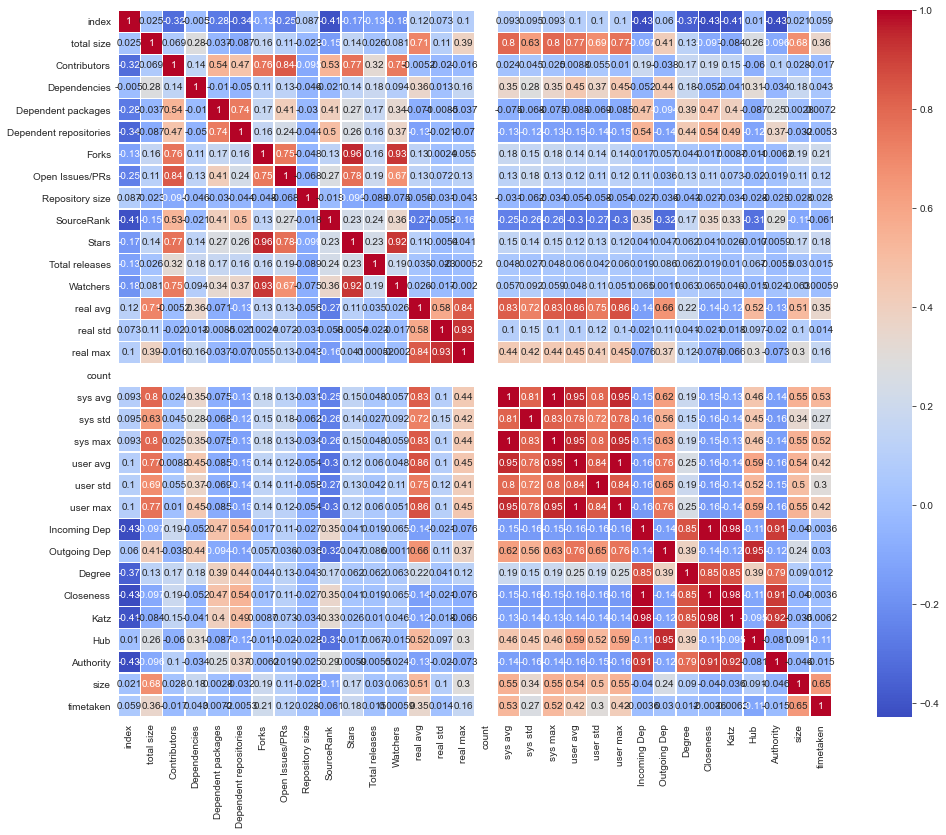

In [1331]:
plt.figure(figsize=(16,13))
heatmap_df = q_df
#heatmap_df["real avg"] = heatmap_df["real avg"].astype(float)
cor = heatmap_df.corr()
sns.heatmap(cor, annot=True, cmap="coolwarm", linewidths=.5)

<a name='choose'></a>
## 5. Choosing columns


<br>

In [1332]:
q_df.columns

Index(['index', 'library', 'dependencies', 'total size', 'size_full',
       'Contributors', 'Dependencies', 'Dependent packages',
       'Dependent repositories', 'First release', 'Forks', 'Latest release',
       'Open Issues/PRs', 'Repository size', 'SourceRank', 'Stars',
       'Total releases', 'Version Number', 'Version Time', 'Watchers',
       'real avg', 'real std', 'real max', 'count', 'sys avg', 'sys std',
       'sys max', 'user avg', 'user std', 'user max', 'dependencies full',
       'Incoming Dep', 'Outgoing Dep', 'Degree', 'Closeness', 'Katz', 'Hub',
       'Authority', 'dependencies_temp', 'size', 'timetaken'],
      dtype='object')

In [1335]:
drop_columns = ['index', 'Dependencies', 'Dependent packages', 'Dependent repositories', 'First release', 'Latest release',
               'Repository size', 'Closeness', 'Katz', 'Hub']

q_df.drop(drop_columns, axis=1)

,library,dependencies,total size,size_full,Contributors,Forks,Open Issues/PRs,SourceRank,Stars,Total releases,...,user std,user max,dependencies full,Incoming Dep,Outgoing Dep,Degree,Authority,dependencies_temp,size,timetaken
0,matplotlib,"[cycler, kiwisolver]",60.000,35M /home/ubuntu/ve/randomenv/lib/python3.6/si...,763.0,5874.0,1663.0,28.0,13806.0,68.0,...,0.152169,5.348,"[six, python-dateutil, cycler, numpy, pyparsin...",75,7,0.073345,0.003557,"[cycler, kiwisolver]",19.496,-0.31275
1,numpy,[],25.000,25M /home/ubuntu/ve/randomenv/lib/python3.6/si...,736.0,5616.0,2333.0,29.0,17445.0,101.0,...,0.082571,2.846,[],271,0,0.242397,0.009493,[],25.000,0.31375
2,pandas,[],74.800,47M /home/ubuntu/ve/randomenv/lib/python3.6/si...,970.0,12560.0,3669.0,28.0,30122.0,93.0,...,0.246785,6.274,"[python-dateutil, six, pytz, numpy]",105,4,0.097496,0.005825,[],31.776,-0.12125
3,scipy,[],87.000,62M /home/ubuntu/ve/randomenv/lib/python3.6/si...,680.0,3755.0,1667.0,26.0,8312.0,66.0,...,0.056700,5.256,[numpy],114,1,0.102862,0.003385,[],61.876,0.24475
4,ipywidgets,"[nbclient, terminado, testpath, jedi, argon2-c...",78.292,39M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,NaN,NaN,17.0,NaN,123.0,...,0.244549,10.311,"[pyzmq, parso, zipp, nbclient, terminado, json...",44,53,0.086762,0.006981,"[nbclient, terminado, testpath, jedi, argon2-c...",-17.704,-0.38325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,imgkit,[],0.060,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,7.0,62.0,NaN,16.0,628.0,31.0,...,0.051176,0.869,[six],0,1,0.000894,0.000000,[],0.000,0.00000
945,sphinx_tabs,"[sphinx, sphinxcontrib-qthelp, imagesize, sphi...",65.700,30M /home/ubuntu/ve/randomenv/lib/python3.6/si...,14.0,43.0,NaN,18.0,157.0,28.0,...,0.155644,5.186,"[sphinx, sphinxcontrib-qthelp, idna, urllib3, ...",0,24,0.021467,0.000000,"[sphinx, sphinxcontrib-qthelp, imagesize, sphi...",-23.712,-0.76850
946,lea,[],0.716,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,0.0,3.0,NaN,9.0,NaN,50.0,...,0.022174,1.460,[],0,0,0.000000,0.000000,[],0.716,0.18450
947,requests-html,"[pyppeteer, fake-useragent, pyquery, parse, bs...",22.080,15M /home/ubuntu/ve/randomenv/lib/python3.6/si...,41.0,823.0,NaN,18.0,11900.0,36.0,...,0.156274,5.397,"[urllib3, pyppeteer, fake-useragent, certifi, ...",0,13,0.011628,0.000000,"[pyppeteer, fake-useragent, pyquery, parse, bs...",17.980,0.25475


In [1336]:
pack_q = q_df.to_json()
with open("q_df.txt",'w') as f:
    json.dump(pack_q, f)

<a name='e1'></a>
## 5. Timing csv EDA


<br>

Let's say for now, we take the real time.

<AxesSubplot:xlabel='real avg', ylabel='Density'>

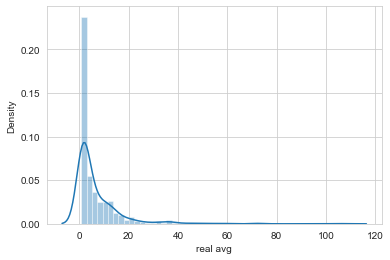

In [450]:
sns.distplot(df["real avg"])

Difference between max and avg for count > 1

In [451]:
bigcount = df[df["count"].apply(lambda x: float(x)) > 1]

<AxesSubplot:>

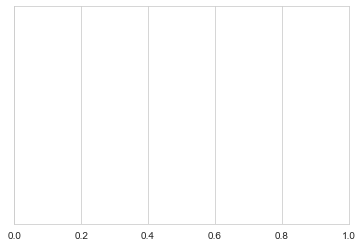

In [452]:
sns.boxplot(bigcount["real max"].astype(float) - bigcount["real avg"].astype(float))

<a name='e2'></a>
## 6. Dependency/size csv EDA

 - Package size
 - Package dependencies
 
 Columns: ['library', 'dependencies', 'size', 'size_full']
<br>

Why is package name not in install?

In [453]:
df["size_full"]

0      35M /home/ubuntu/ve/randomenv/lib/python3.6/si...
1      25M /home/ubuntu/ve/randomenv/lib/python3.6/si...
2      47M /home/ubuntu/ve/randomenv/lib/python3.6/si...
3      62M /home/ubuntu/ve/randomenv/lib/python3.6/si...
4      39M /home/ubuntu/ve/randomenv/lib/python3.6/si...
                             ...                        
995    11M /home/ubuntu/ve/randomenv/lib/python3.6/si...
996    30M /home/ubuntu/ve/randomenv/lib/python3.6/si...
997    11M /home/ubuntu/ve/randomenv/lib/python3.6/si...
998    15M /home/ubuntu/ve/randomenv/lib/python3.6/si...
999    11M /home/ubuntu/ve/randomenv/lib/python3.6/si...
Name: size_full, Length: 949, dtype: object

In [454]:
counter = 0
for index, row in df.iterrows():
    counter += row["library"] in (row["size_full"]) 
counter / len(df)

0.6080084299262382

Standard stuff:

<AxesSubplot:xlabel='size', ylabel='Count'>

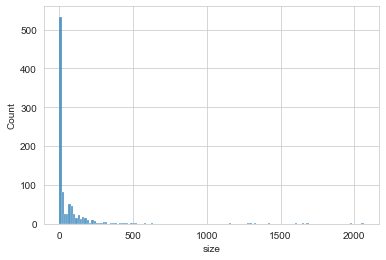

In [462]:
sns.histplot(df["size"])

(0.0, 200.0)

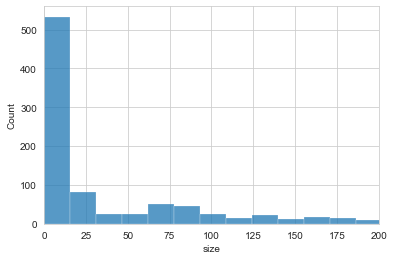

In [472]:
fig, ax = plt.subplots()
sns.histplot(df["size"], ax=ax)
ax.set_xlim(0,200)

dep_len

<AxesSubplot:xlabel='dep_len', ylabel='Count'>

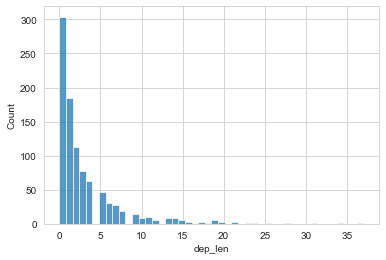

In [573]:
sns.histplot(df["dep_len"])

In [583]:
df.sort_values('dep_len', ascending=False)

,library,dependencies,size,size_full,Contributors,Dependencies,Dependent packages,Dependent repositories,First release,Forks,...,real std,real max,count,sys avg,sys std,sys max,user avg,user std,user max,dep_len
769,spyder,"[qtawesome, keyring, rtree, pygments, numpydoc...",173.480,45M /home/ubuntu/ve/randomenv/lib/python3.6/si...,156.0,56.0,29.0,898.0,"Sep 18, 2014",1270.0,...,NaN,32.246,1.0,2.555,NaN,2.555,27.615,NaN,27.615,37
564,datapane,"[nbconvert, requests-toolbelt, packaging, json...",421.956,128M /home/ubuntu/ve/randomenv/lib/python3.6/s...,NaN,33.0,0.0,0.0,"Nov 12, 2019",NaN,...,NaN,36.001,1.0,3.263,NaN,3.263,30.019,NaN,30.019,34
595,msticpy,"[pandas, KqlmagicCustom, networkx, azure-mgmt-...",307.520,59M /home/ubuntu/ve/randomenv/lib/python3.6/si...,12.0,80.0,1.0,2.0,"Mar 7, 2019",97.0,...,NaN,36.822,1.0,2.954,NaN,2.954,32.184,NaN,32.184,31
507,tfx,"[apache-beam, attrs, packaging, pyyaml, tensor...",1295.408,927M /home/ubuntu/ve/randomenv/lib/python3.6/s...,NaN,48.0,1.0,2.0,"Mar 2, 2019",459.0,...,NaN,103.522,1.0,6.967,NaN,6.967,67.545,NaN,67.545,28
737,geemap,"[sankee, geocoder, pandas, ipynb-py-convert, i...",353.540,133M /home/ubuntu/ve/randomenv/lib/python3.6/s...,1.0,25.0,2.0,0.0,"Mar 8, 2020",522.0,...,NaN,41.144,1.0,3.607,NaN,3.607,35.108,NaN,35.108,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,pamela,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,6.0,0.0,6.0,117.0,"Sep 8, 2015",9.0,...,NaN,0.939,1.0,0.082,NaN,0.082,0.760,NaN,0.760,0
459,coverage,[],1.300,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,105.0,1.0,3790.0,50200.0,"May 16, 2009",219.0,...,NaN,1.480,1.0,0.111,NaN,0.111,1.329,NaN,1.329,0
457,ipython_genutils,[],0.000,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,117.0,3280.0,"Apr 9, 2015",NaN,...,NaN,0.888,1.0,0.088,NaN,0.088,0.772,NaN,0.772,0
452,unidecode,[],2.100,11M /home/ubuntu/ve/randomenv/lib/python3.6/si...,NaN,0.0,545.0,7350.0,"Jun 17, 2009",NaN,...,NaN,1.132,1.0,0.117,NaN,0.117,0.981,NaN,0.981,0


<a name='e3'></a>
## 7. Scrape csv EDA

 - Package stats
 - Package versions
 
 Columns: ['library', 'Contributors', 'Dependencies', 'Dependent packages', 'Dependent repositories', 'First release', 'Forks', 'Latest release', 'Open Issues/PRs', 'Repository size', 'SourceRank', 'Stars', 'Total releases', 'Version Number', 'Version Time', 'Watchers']
<br>

Version related stuff:

<a name='c1'></a>
## 8. Scatterplots

<br>

<AxesSubplot:xlabel='size', ylabel='real avg'>

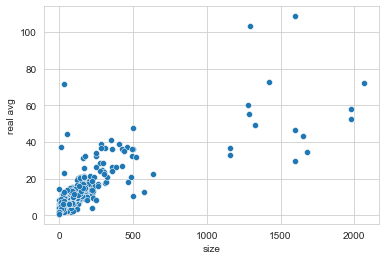

In [495]:
sns.scatterplot(x="size", y="real avg", data=df)

<AxesSubplot:xlabel='dep_len', ylabel='real avg'>

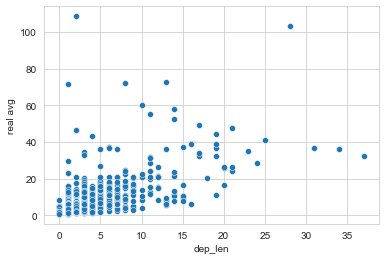

In [493]:
sns.scatterplot(x="dep_len", y="real avg", data=df)

<AxesSubplot:xlabel='size', ylabel='Repository size'>

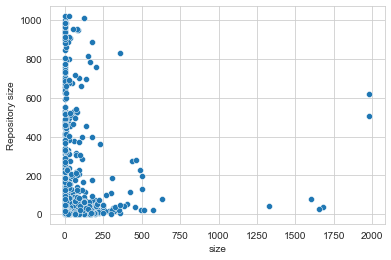

In [494]:
sns.scatterplot(x="size", y="Repository size", data=df)

<AxesSubplot:xlabel='Stars', ylabel='Forks'>

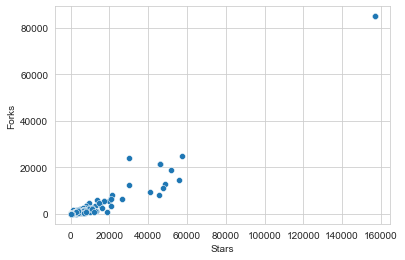

In [527]:
sns.scatterplot(x="Stars", y="Forks", data=df)